In [1]:
#!/usr/bin/env python
# import analyzer
import importlib
from importlib import reload
import os, sys, glob, warnings, glob
import numpy as np
import scipy as sp
import joblib
# from tqdm.notebook import tqdm
from tqdm import tqdm
import ROOT as root

import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

Welcome to JupyROOT 6.24/06


In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
muon_energy=100
print("Processing energy ",muon_energy, "GeV")

data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/muon_{muon_energy}_GeV/*/*/stat*.root",)
files=util.Utils.sortByExt(files)

tfile = root.TFile.Open(files[0])
Tree = tfile.Get("integral_tree")
nevents = int(Tree.GetEntries())   

truth=[]
recon=[]
recon_unc=[]
digi=[]
digi2=[]
ievent=[]
ifile=[]
ndigi=np.zeros(nevents)
n_events=np.zeros(nevents)
n_failed=np.zeros(nevents)

for i,filename in enumerate(tqdm(files)):
    tfile = root.TFile.Open(filename)
    tree_name = ["integral_tree","box_run"][0]
    Tree = tfile.Get(tree_name)

    for Entry in range(nevents):
        Tree.GetEntry(Entry)
        try:
#             if 1:
            n_events[Entry]+=1
            ndigi[Entry]=len(Tree.Digi_x)
        
            recon.append([Tree.Track_k_m_z0[0], Tree.Track_k_m_x0[0], Tree.Track_k_m_y0[0], Tree.Track_k_m_t0[0],Tree.Track_k_m_velZ[0], Tree.Track_k_m_velX[0], Tree.Track_k_m_velY[0]])
            ievent.append(Entry)
            ifile.append(i)
            
            recon_unc.append([Tree.Track_k_m_ErrorZ0[0], Tree.Track_k_m_ErrorX0[0], Tree.Track_k_m_ErrorY0[0], Tree.Track_k_m_ErrorT0[0],Tree.Track_k_m_ErrorVz[0], Tree.Track_k_m_ErrorVx[0], Tree.Track_k_m_ErrorVy[0]])
            truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0],Tree.Hit_particlePz[0], Tree.Hit_particlePx[0], Tree.Hit_particlePy[0]])
            digi.append([Tree.Digi_z[0], Tree.Digi_x[0], Tree.Digi_y[0], Tree.Digi_time[0]])
            digi2.append([Tree.Digi_z[1], Tree.Digi_x[1], Tree.Digi_y[1], Tree.Digi_time[1]])

        except:
            n_failed[Entry]+=1

truth=np.array(truth)
recon=np.array(recon)
recon_unc=np.array(recon_unc)
ievent=np.array(ievent)
ifile=np.array(ifile)
ndigi=np.array(ndigi)
digi=np.array(digi)
digi2=np.array(digi2)

Processing energy  100 GeV


100%|██████████| 200/200 [00:16<00:00, 11.88it/s]


Text(0, 0.5, 'Reconstructed x0 [cm]')

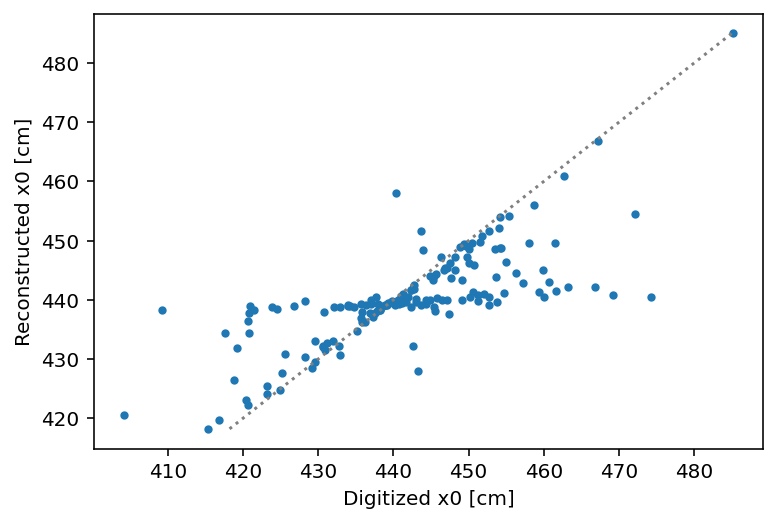

In [67]:
i=9
plt.scatter(digi[:,1][ievent==i],recon[:,1][ievent==i],s=10)
diag = [min(recon[:,1][ievent==i]),max(recon[:,1][ievent==i])]
plt.plot(diag,diag,color="grey",linestyle=":")
plt.xlabel("Digitized x0 [cm]")
plt.ylabel("Reconstructed x0 [cm]")

Text(0, 0.5, 'Reconstructed vx [cm/ns]')

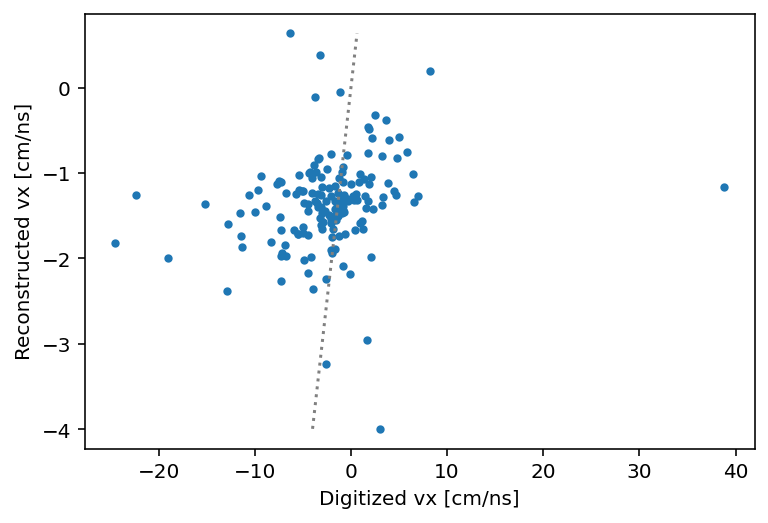

In [72]:
i=9
vxdigi = (digi2[:,1][ievent==i]-digi[:,1][ievent==i])/(digi2[:,3][ievent==i]-digi[:,3][ievent==i])
vxrecon = recon[:,5][ievent==i]

plt.scatter(vxdigi,vxrecon,s=10)
diag = [min(vxrecon),max(vxrecon)]
plt.plot(diag,diag,color="grey",linestyle=":")
plt.xlabel("Digitized vx [cm/ns]")
plt.ylabel("Reconstructed vx [cm/ns]")

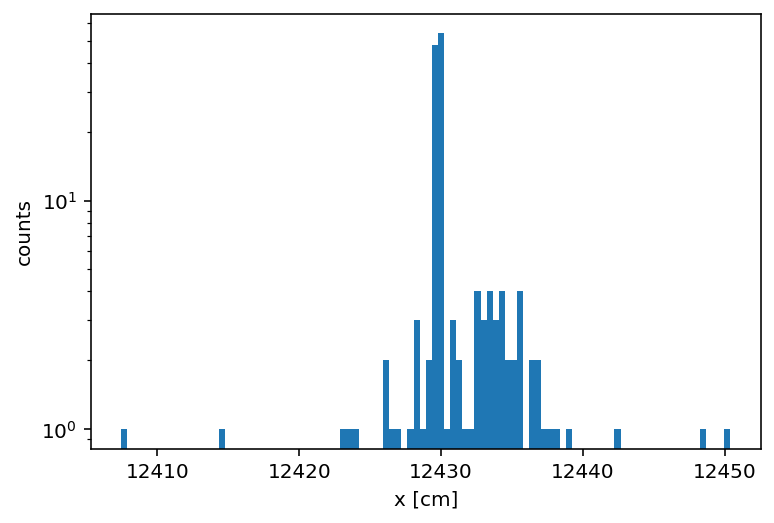

In [44]:
plt.hist(recon[:,0][ievent==6],bins=100);
plt.xlabel("x [cm]")
plt.ylabel('counts')
plt.yscale("log")

## Seeding?

In [8]:
# Data preparation:
# get all tracks that have 7 hits (one hit per layer)
cut=cutflow.sample_space("")

def get_digi_hits(ev):
    ev.Tree.GetEntry(ev.EventNumber)
    hits=[]
    for ii in range(len(ev.Tree.Digi_y)):
        hit=Hit(ev.Tree.Digi_x[ii], ev.Tree.Digi_y[ii], ev.Tree.Digi_z[ii], ev.Tree.Digi_time[ii])
        hit.get_uncertainty()
        hits.append(hit)
    return hits

def get_event_truth(ev):
    ev.Tree.GetEntry(ev.EventNumber)
    dx=ev.Tree.Hit_x[1]-ev.Tree.Hit_x[0]
    dy=ev.Tree.Hit_y[1]-ev.Tree.Hit_y[0]
    dz=ev.Tree.Hit_z[1]-ev.Tree.Hit_z[0]
    dt=ev.Tree.Hit_time[1]-ev.Tree.Hit_time[0]
    truth=[ev.Tree.Hit_x[0], ev.Tree.Hit_y[0], ev.Tree.Hit_z[0], ev.Tree.Hit_time[0],dx/dt, dy/dt, dz/dt]
    return truth

class Hit:
    def __init__(self, x, y, z, t):
        self.x=x
        self.y=y
        self.z=z
        self.t=t
        self.t_uncertainty=1
    def get_uncertainty(self):
        # Get the layer-dependent uncertainty of each hit
        self.hit_layer=cut.in_layer(self.y)
        hit_uncertainty = np.array(detector.Layer().uncertainty(self.hit_layer))
        self.x_uncertainty=hit_uncertainty[0]*100 # m->cm
        self.y_uncertainty=hit_uncertainty[1]*100 # m->cm
        self.z_uncertainty=hit_uncertainty[2]*100 # m->cm
#         self.y_uncertainty=2/np.sqrt(12)

def gen_hits(Vx=2,Vy=25,Vz=3,x0=450,z0=450+11950):
    Y_LAYERS = np.array([0,1, 5,6,7,8,9])*100 #cm
    unc_low = 0.04/np.sqrt(12)*100 #cm
    unc_high = 1*sp.constants.c/1e7/np.sqrt(2)/1.5 #cm
    UNC_X = [unc_low,unc_high,unc_low,unc_high,unc_low,unc_high,unc_low]
    UNC_Z = [unc_high,unc_low,unc_high,unc_low,unc_high,unc_low,unc_high]
    unc_low2=unc_low
    UNC_X_multi = [unc_low2,unc_high,unc_low2,unc_high,unc_low2,unc_high,unc_low2]
    UNC_Z_multi = [unc_high,unc_low2,unc_high,unc_low2,unc_high,unc_low2,unc_high]    
    UNC_T = 1 #ns
    UNC_Y = 2/np.sqrt(12) #uncertainty in thickness, cm

    hits=[]
    hits_truth=[]
    hits_err=[]
    for i in range(len(Y_LAYERS)):
        t=(Y_LAYERS[i]-Y_LAYERS[0])/Vy
        hits_truth.append([x0+Vx*t,Y_LAYERS[i], z0+Vz*t, t])
        hits.append(Hit(x0+Vx*t+np.random.normal(0,1)*UNC_X_multi[i],
                        Y_LAYERS[i],
                        z0+Vz*t+np.random.normal(0,1)*UNC_Z_multi[i],
                        t+np.random.normal(0,UNC_T)))
        hits[-1].x_uncertainty=UNC_X[i]
        hits[-1].z_uncertainty=UNC_Z[i]
        hits[-1].y_uncertainty=UNC_Y
        hits_err.append([UNC_X[i],UNC_Y,UNC_Z[i],UNC_T])
        
    return np.array(hits),np.array(hits_err),np.array(hits_truth)

In [9]:
# Pull hits from simulation

muon_energy=1000
print("Processing energy ",muon_energy, "GeV")

data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/muon_{muon_energy}_GeV/*/*/stat*.root",)
files=util.Utils.sortByExt(files)

Hit_collection = []
Truth_collection = []
hit_inds=[]
for i_file in tqdm(range(len(files))):
# for i_file in tqdm(range(10)):
    filename=files[i_file]
    tree_name="integral_tree"
    ev = event.Event(filename, 0, tree_name=tree_name)
    nevents = int(ev.Tree.GetEntries())

    for i_event in range(1):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)
#         if len(ev.Tree.Digi_x)==7:
        if 1:
            hit_inds.append(i_event)
            hits = get_digi_hits(ev)
            truth =  get_event_truth(ev)
            
            Hit_collection.append(hits)
            Truth_collection.append(truth)

Processing energy  1000 GeV


100%|██████████| 200/200 [00:13<00:00, 14.37it/s]


In [15]:
def Seed(hits):
    c=29.97
    seeds=[]
    for i in range(len(hits)):
        for j in range(i+1, len(hits)):
            dx = hits[i].x- hits[j].x
            dy = hits[i].y- hits[j].y
            dz = hits[i].z- hits[j].z
            dt = hits[i].t- hits[j].t
            ds = (dx**2+dy**2-dz**2)/c**2-dt**2
#             print(i,j, ds)
#             print(hits[i].x, hits[i].z,hits[j].x, hits[j].z)
#             if ds>5:
#                 continue
                
#             seeds.append([hits[i],hits[j]])
#             seeds.append([i,j,ds])
            seeds.append(ds)
    return np.array(seeds)

all_seeds=[]
for hits in Hit_collection:
    all_seeds.append(Seed(hits))
all_seeds=np.array(all_seeds)

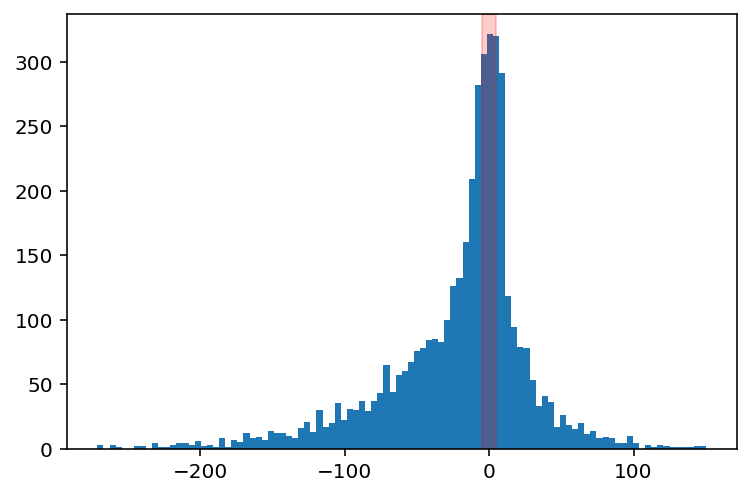

In [19]:
plt.hist(all_seeds.flatten(),bins=100);
plt.axvspan(-5,5,color="r",alpha=0.2)

In [18]:
mask = (recon[:,0]>12440) & (ievent==6)
ifile[mask]

array([ 29,  42, 155])

In [17]:
filename = files[29]
print(filename,"\n")

# 2. Open file and print branches
tfile = root.TFile.Open(filename)
tree_name = ["integral_tree","box_run"][0]
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

/project/def-mdiamond/tomren/mathusla/data/fit_study/muon_100_GeV/20230129/191525/stat30.root 

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_m_chi2', 'Vertex_k_m_trackIndices', 'NumVertices_k_m', 'Track_k_m_velX', 'Track_k_m_velY', '

In [38]:
list(Tree.z_estimates_m),list(Tree.Digi_z),list(Tree.Track_k_m_x_std_scat_per_m)

([12442.575749383688,
  12426.12447084305,
  12384.741090053296,
  12373.822083470051,
  12366.511557997823,
  12354.340522869037,
  12344.257768149817,
  -1.0],
 [12429.75,
  12420.52997067806,
  12384.75,
  12364.631267061017,
  12366.75,
  12335.063571826857,
  12344.25],
 [13.816851454602077,
  9.454688382613858,
  6.894036643350904,
  5.544914396693552,
  5.122895986263579,
  3.424692695564045])

In [18]:
Tree.GetEntry(6);

# print(Tree.Digi_numHits[:10]),len(Tree.Digi_energy)

# for i in range(int(Tree.NumHits)):
#     print(Tree.Hit_x[i], Tree.Hit_y[i], Tree.Hit_z[i], Tree.Hit_energy[i], Tree.Hit_time[i])

for i in range(len(Tree.Digi_numHits)):
    print(Tree.Digi_x[i], Tree.Digi_time[i], Tree.Digi_y[i],Tree.Digi_energy[i], Tree.Digi_particle_energy[i], Tree.Digi_pdg_id[i], Tree.Digi_seed)

468.66456363342223 8552.5 12430.776671181477 3.5192180359383443 6.912764817368634
477.8885409320744 8654.01582079742 12421.279866405706 0.7899614540601939 10.327644186138484
478.023420953766 8655.5 12421.141054196854 2.8435836342289633 10.377570295076314
514.0963765503205 9052.5 12384.033754111142 3.8113774057436793 23.732111552214747
523.3821314591918 9154.600526211489 12374.491552730165 1.883249595776074 27.166656999238203
523.4639159811827 9155.5 12374.407512746304 1.6324922161664812 27.196914139245624
532.8281637266583 9258.5 12364.783343713165 3.928244587230718 30.6617004208153
542.1897996701426 9361.451436205169 12355.164726781491 3.789300991773686 34.12485536836162
542.1942156355602 9361.5 12355.160189630922 0.07101055422293658 34.1264889919486
551.4102159791267 9462.873359689469 12345.689339806042 0.5386131826453647 37.53655201415922
551.5120588417623 9463.993950047963 12345.584679055079 1.793908925143074 37.574246971071
551.5580489385702 9464.5 12345.537421602836 0.73420958514